Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.4996 - loss: 0.7115 - val_accuracy: 0.8052 - val_loss: 0.6393 - learning_rate: 1.0000e-04
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.5165 - loss: 0.6918 - val_accuracy: 0.2283 - val_loss: 0.7137 - learning_rate: 1.0000e-04
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5868 - loss: 0.6868 - val_accuracy: 0.6587 - val_loss: 0.6831 - learning_rate: 1.0000e-04
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6239 - loss: 0.6839 - val_accuracy: 0.6841 - val_loss: 0.6772 - learning_rate: 1.0000e-04
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6522 - loss: 0.6814 - val_accuracy: 0.5945 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6503 - loss: 0.6794 - val_accuracy: 0.5912 - val_loss: 0.6836 - learning_rate: 1.0000e-05
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6475 - loss: 0

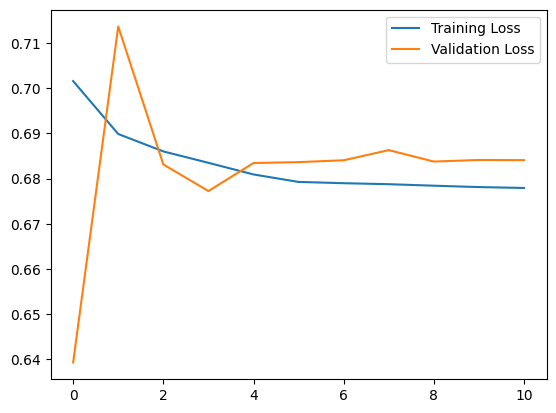

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.41790330301579703
Precision: 0.21693491952414276
Recall: 0.7616707616707616
F1 Score: 0.33769063180827885


In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load datasets
dataframe_train = pd.read_csv('BATADAL_dataset04.csv')
dataframe_test = pd.read_csv('BATADAL_test_dataset.csv')

# Replace -999 with 0 in the datasets
dataframe_train.replace(-999, 0, inplace=True)
dataframe_test.replace(-999, 0, inplace=True)

# Preprocess training data
train_data = dataframe_train.drop(dataframe_train.columns[[0, -1]], axis=1)  # Remove date and label columns
train_labels = dataframe_train.iloc[:, -1].astype(bool)  # Convert labels to boolean

# Preprocess testing data
test_data = dataframe_test.drop(dataframe_test.columns[[0, -1]], axis=1)  # Remove date and label columns
test_labels = dataframe_test.iloc[:, -1].astype(bool)  # Convert labels to boolean

# Normalize data using training dataset stats
min_val = train_data.min().min()
max_val = train_data.max().max()

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Reshape data to 2D format (height=1, width=num_features, channels=1) for CNN
train_data = np.reshape(train_data.values, (-1, train_data.shape[1], 1))
test_data = np.reshape(test_data.values, (-1, test_data.shape[1], 1))

# Handle imbalanced data using SMOTE
smote = SMOTE()
train_data_reshaped = train_data.reshape(train_data.shape[0], -1)
train_data_resampled, train_labels_resampled = smote.fit_resample(train_data_reshaped, train_labels)
train_data_resampled = train_data_resampled.reshape(-1, train_data.shape[1], 1)

# CNN model for classification
class AnomalyDetectorCNN(tf.keras.Model):
    def __init__(self):
        super(AnomalyDetectorCNN, self).__init__()
        self.conv1 = layers.Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(train_data.shape[1], 1))
        self.pool1 = layers.MaxPooling1D(2, padding='same')
        self.dropout1 = layers.Dropout(0.5)

        self.conv2 = layers.Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.pool2 = layers.MaxPooling1D(2, padding='same')
        self.dropout2 = layers.Dropout(0.5)

        self.conv3 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')
        self.pool3 = layers.MaxPooling1D(2, padding='same')
        self.dropout3 = layers.Dropout(0.5)

        self.global_pool = layers.GlobalAveragePooling1D()
        self.dense1 = layers.Dense(128, activation='relu', kernel_initializer='he_normal')
        self.dropout4 = layers.Dropout(0.5)
        self.dense2 = layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = self.global_pool(x)
        x = self.dense1(x)
        x = self.dropout4(x)
        x = self.dense2(x)
        return x

# Instantiate and compile the CNN model
custom_learning_rate = 0.0001  # Custom learning rate to avoid overfitting
optimizer = Adam(learning_rate=custom_learning_rate)
cnn_model = AnomalyDetectorCNN()
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the CNN model on the training data
history = cnn_model.fit(
    train_data_resampled, train_labels_resampled,
    epochs=20,
    batch_size=512,
    validation_data=(test_data, test_labels),
    shuffle=True,
    callbacks=[early_stopping, lr_scheduler_callback]
)

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Make predictions on the entire test dataset
test_predictions = cnn_model.predict(test_data)

# Find optimal threshold using Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, test_predictions)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
test_predictions = (test_predictions > optimal_threshold).astype(int)

# Evaluate metrics
def print_stats(predictions, labels):
    print("Accuracy:", accuracy_score(labels, predictions))
    print("Precision:", precision_score(labels, predictions))
    print("Recall:", recall_score(labels, predictions))
    print("F1 Score:", f1_score(labels, predictions))

# Print the evaluation metrics
print_stats(test_predictions, test_labels)